# STATS 507 Final Project Code

## Please make sure you have the following packages installed in order to run the models! 
### Thank you :-)

In [ ]:
import requests
import zipfile
### Use zipfile36 if you are using older Python versions.
# import zipfile 36
import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50

### If Not, you may adjust this trunk to install any missing package(s)!

In [ ]:
#!pip install requests
#!pip install zipfile
#!pip install zipfile36 
### Use zipfile36 if you are using older Python versions.
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install Pillow
#!pip install seaborn
#!pip install sklearn
#!pip install tensorflow

## Objectives
### 1. Create cat and dog classification models.
### 2. Conduct a comparative analysis for the models.

## Data Preprocess


In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

base_dir = "/Users/cathy/Desktop/dogcat"  

filenames = []
labels = []

for label in ['cat', 'dog']:
    label_dir = os.path.join(base_dir, label)
    for filename in os.listdir(label_dir):
        filenames.append(os.path.join(label, filename))
        labels.append(label)

data = pd.DataFrame({"filename": filenames, "label": labels})
print(data.head())

            filename label
0   cat/cat.5077.jpg   cat
1   cat/cat.2718.jpg   cat
2  cat/cat.10151.jpg   cat
3   cat/cat.3406.jpg   cat
4   cat/cat.4369.jpg   cat


## I directly imported the data needed from my local desktop, but you can also run the following trunck and it will allow you to access the data through dropbox and label them as needed.

In [ ]:
import requests
import zipfile
import io
import pandas as pd

def process_zip_from_dropbox(dropbox_link):
    filenames = []
    labels = []
    
    response = requests.get(dropbox_link)
    if response.status_code == 200:
        print(f"Successfully fetched the zip file from {dropbox_link}")
    else:
        print(f"Failed to fetch the zip file from {dropbox_link}")
        return pd.DataFrame()
    
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    
    for file_info in zip_file.infolist():
        if not file_info.is_dir(): 
            path_parts = file_info.filename.split('/')
            if len(path_parts) == 2:  
                label, filename = path_parts
                if label in ['cat', 'dog']:  
                    filenames.append(file_info.filename)
                    labels.append(label)
    
    return pd.DataFrame({"filename": filenames, "label": labels})

# Dropbox links for the two zip files
dropbox_link_1 = "https://www.dropbox.com/scl/fi/v52ne0q7uiay4tnyedpjt/cat.zip?rlkey=p5p13z2lnp94zq3rr2sehmmvu&st=l7wloz5v&dl=1"
dropbox_link_2 = "https://www.dropbox.com/scl/fi/t4ny0wj0lvdapm0nfxbp3/dog.zip?rlkey=ycibqylva74tayaex3mggvmzl&st=ygbx9sqo&dl=1"

data_1 = process_zip_from_dropbox(dropbox_link_1)
data_2 = process_zip_from_dropbox(dropbox_link_2)

combined_data = pd.concat([data_1, data_2], ignore_index=True)

print(combined_data.head())


## EDA 
### Visualizing the distribution of labels and displaying sample images.

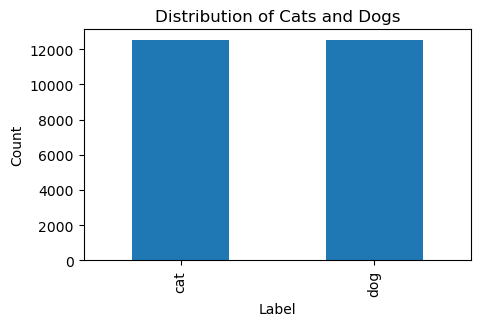

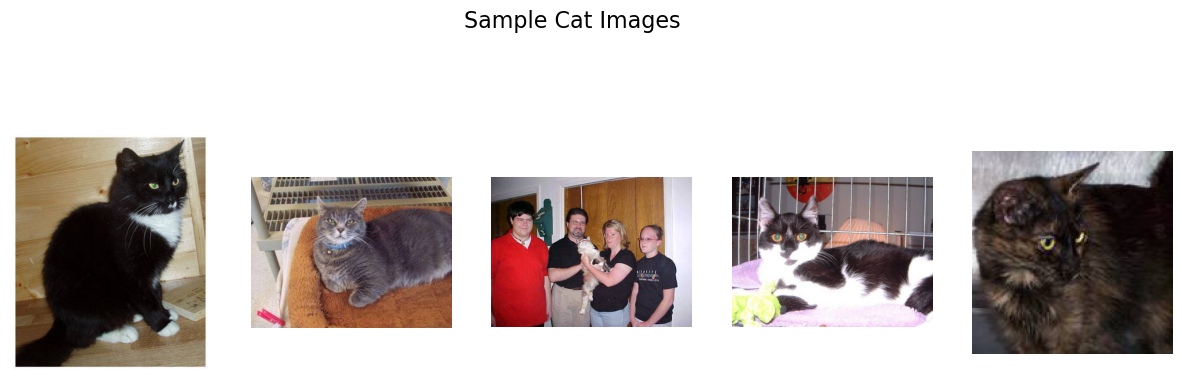

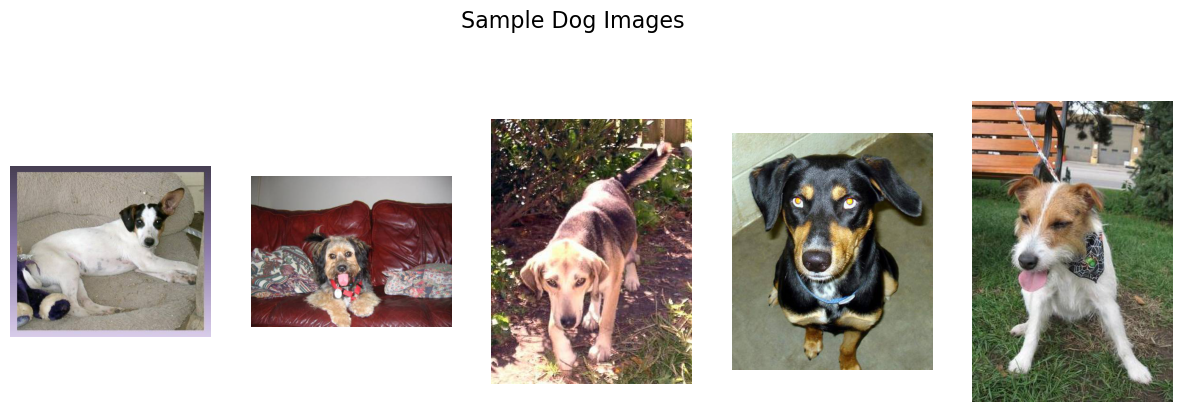

In [25]:
plt.figure(figsize=(5, 3))
data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Cats and Dogs')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

def display_sample_images(base_dir, data, label, sample_size=5):
    sample_data = data[data['label'] == label].sample(sample_size)
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))
    for img_name, ax in zip(sample_data['filename'], axes):
        img_path = os.path.join(base_dir, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f'Sample {label.capitalize()} Images', fontsize=16)
    plt.show()

# Some sample cat images
display_sample_images(base_dir, data, 'cat')

# Some sample dog images
display_sample_images(base_dir, data, 'dog')

# Model 1: CNN


Found 19999 validated image filenames belonging to 2 classes.
Found 5001 validated image filenames belonging to 2 classes.


/Applications/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


label
dog    10000
cat    10000
Name: count, dtype: int64
label
cat    2501
dog    2500
Name: count, dtype: int64


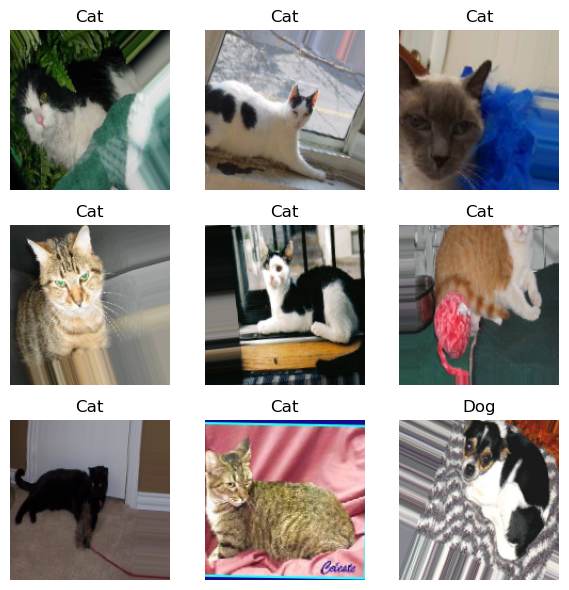

In [31]:
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory=base_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory=base_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

print(train_data['label'].value_counts())
print(test_data['label'].value_counts())

sample_training_images, sample_training_labels = next(train_generator)
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_training_images[i])
    label = 'Cat' if sample_training_labels[i] == 0 else 'Dog'
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),  
    
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [33]:
history = model.fit(
    train_generator,  
    epochs=15, 
    validation_data=test_generator 
)


Epoch 1/15


2024-11-03 19:30:15.204045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-03 19:30:15.238948: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


625/625 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5458

2024-11-03 19:32:32.365091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 148s 236ms/step - loss: 0.6870 - accuracy: 0.5458 - val_loss: 0.6566 - val_accuracy: 0.6227
Epoch 2/15
625/625 [==============================] - 152s 244ms/step - loss: 0.6605 - accuracy: 0.6092 - val_loss: 0.5921 - val_accuracy: 0.6995
Epoch 3/15
625/625 [==============================] - 154s 246ms/step - loss: 0.6257 - accuracy: 0.6543 - val_loss: 0.5794 - val_accuracy: 0.6913
Epoch 4/15
625/625 [==============================] - 155s 248ms/step - loss: 0.5962 - accuracy: 0.6821 - val_loss: 0.5485 - val_accuracy: 0.7243
Epoch 5/15
625/625 [==============================] - 157s 251ms/step - loss: 0.5640 - accuracy: 0.7072 - val_loss: 0.5014 - val_accuracy: 0.7590
Epoch 6/15
625/625 [==============================] - 156s 250ms/step - loss: 0.5430 - accuracy: 0.7258 - val_loss: 0.4600 - val_accuracy: 0.7844
Epoch 7/15
625/625 [==============================] - 157s 251ms/step - loss: 0.5246 - accuracy: 0.7424 - val_loss: 0.4563 - val_accura

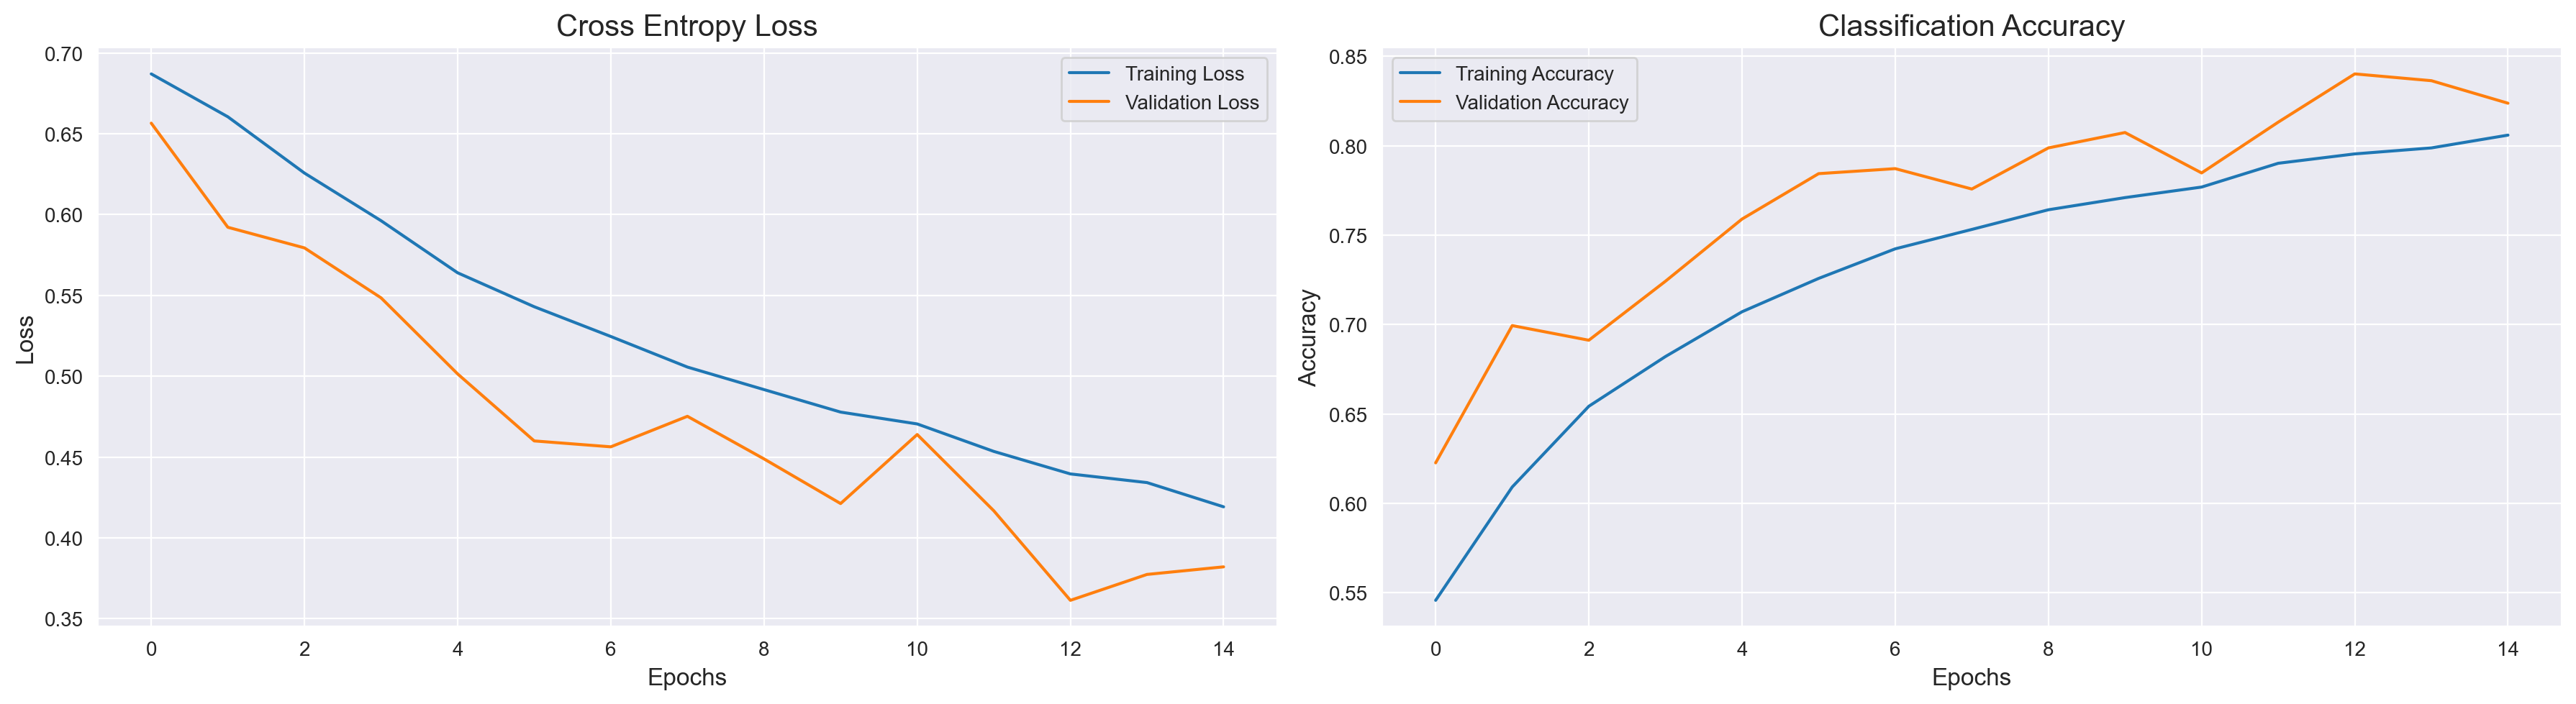

In [35]:
import seaborn as sns

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(1, 2, 1)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


  2/157 [..............................] - ETA: 10s - loss: 0.3595 - accuracy: 0.8438

2024-11-03 20:12:49.950765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


157/157 [==============================] - 10s 66ms/step - loss: 0.3821 - accuracy: 0.8238
Test Loss: 0.3821
Test Accuracy: 82.38%


1/1 [==============================] - 0s 66ms/step


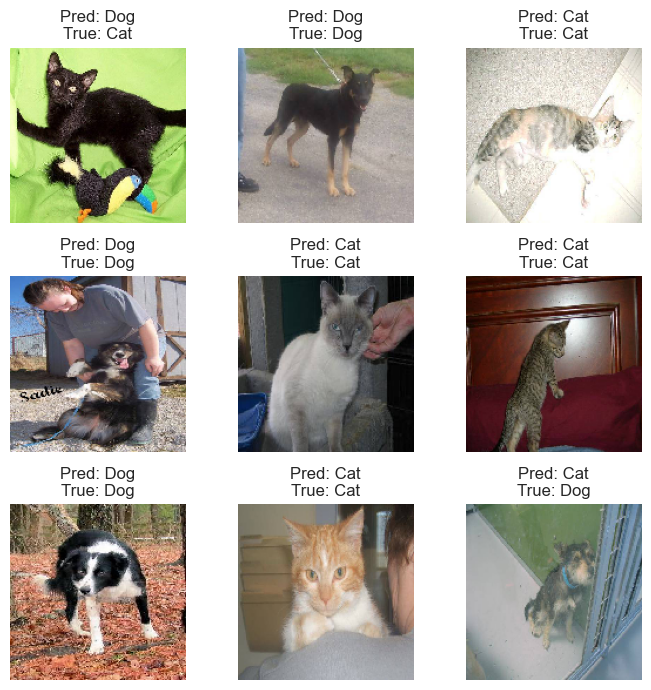

In [38]:
sample_test_images, sample_test_labels = next(test_generator)
predictions = model.predict(sample_test_images)

predicted_labels = (predictions > 0.5).astype(int).flatten()

plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_test_images[i])
    pred_label = 'Dog' if predicted_labels[i] == 1 else 'Cat'
    true_label = 'Dog' if sample_test_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()


  2/156 [..............................] - ETA: 10s

2024-11-03 20:58:15.899700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


156/156 [==============================] - 10s 66ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.39      0.44      2496
         Dog       0.50      0.61      0.55      2496

    accuracy                           0.50      4992
   macro avg       0.50      0.50      0.50      4992
weighted avg       0.50      0.50      0.50      4992



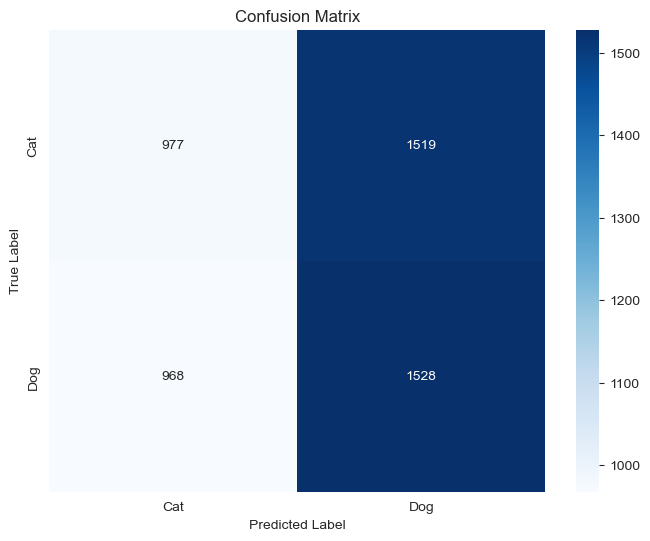

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

test_steps = test_generator.samples // test_generator.batch_size
test_generator.reset() 
predictions = model.predict(test_generator, steps=test_steps, verbose=1)

predicted_labels = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes[:len(predicted_labels)]  
print('Classification Report:')
labels = ['Cat', 'Dog']
print(classification_report(true_labels, predicted_labels, target_names=labels))

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Model 2: ResNet 50

### Freindly Reminder(if you are reproduce the result):  ResNet50 takes a long time (about 12 hours) to run.

### Fit, complie, and fine-tuning the model:

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x) 
predictions = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    epochs=5,  
    validation_data=test_generator
)

base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs= 10,  
    validation_data=test_generator
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

2024-11-04 08:45:23.947197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5380

2024-11-04 08:50:36.443339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 390s 622ms/step - loss: 0.6955 - accuracy: 0.5380 - val_loss: 0.6773 - val_accuracy: 0.5643
Epoch 2/5
625/625 [==============================] - 391s 626ms/step - loss: 0.6827 - accuracy: 0.5589 - val_loss: 0.6720 - val_accuracy: 0.5993
Epoch 3/5
625/625 [==============================] - 405s 647ms/step - loss: 0.6815 - accuracy: 0.5618 - val_loss: 0.6788 - val_accuracy: 0.5383
Epoch 4/5
625/625 [==============================] - 406s 650ms/step - loss: 0.6797 - accuracy: 0.5705 - val_loss: 0.6646 - val_accuracy: 0.6057
Epoch 5/5
625/625 [==============================] - 426s 682ms/step - loss: 0.6777 - accuracy: 0.5755 - val_loss: 0.6614 - val_accuracy: 0.6119


Epoch 1/10


2024-11-04 09:19:02.764389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.8447

2024-11-04 09:51:18.264700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 2011s 3s/step - loss: 0.5006 - accuracy: 0.8447 - val_loss: 0.7939 - val_accuracy: 0.6295
Epoch 2/10
625/625 [==============================] - 1361s 2s/step - loss: 0.1749 - accuracy: 0.9311 - val_loss: 0.0855 - val_accuracy: 0.9698
Epoch 3/10
625/625 [==============================] - 1326s 2s/step - loss: 0.1288 - accuracy: 0.9494 - val_loss: 0.0815 - val_accuracy: 0.9706
Epoch 4/10
625/625 [==============================] - 3747s 6s/step - loss: 0.1019 - accuracy: 0.9603 - val_loss: 0.0717 - val_accuracy: 0.9740
Epoch 5/10
625/625 [==============================] - 6760s 11s/step - loss: 0.0850 - accuracy: 0.9672 - val_loss: 0.0719 - val_accuracy: 0.9746
Epoch 6/10
625/625 [==============================] - 1986s 3s/step - loss: 0.0763 - accuracy: 0.9708 - val_loss: 0.0716 - val_accuracy: 0.9752
Epoch 7/10
625/625 [==============================] - 8079s 13s/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.0643 - val_accuracy: 0.9788
E

### Plot Training and Validation Curves:

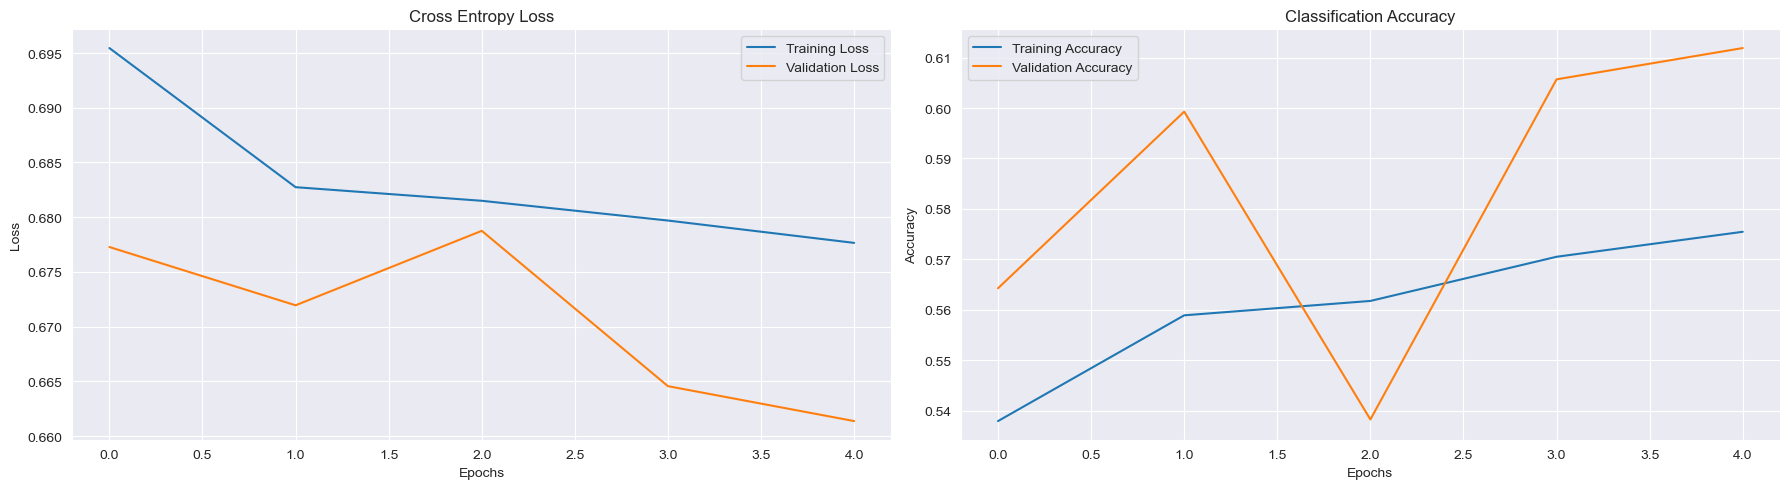

In [50]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Example Output：

1/1 [==============================] - 0s 403ms/step


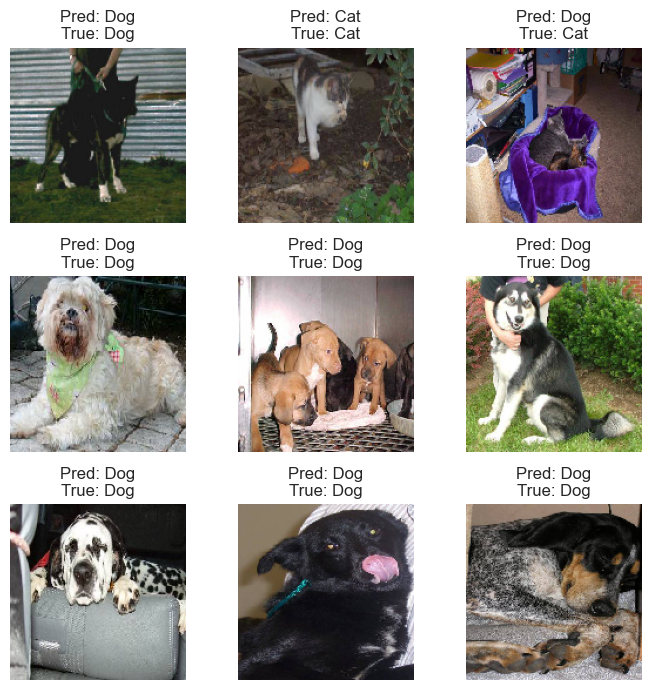

In [48]:
sample_test_images, sample_test_labels = next(test_generator)
predictions = model.predict(sample_test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_test_images[i])
    pred_label = 'Dog' if predicted_labels[i] == 1 else 'Cat'
    true_label = 'Dog' if sample_test_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Plot Classification Report and Confusion Matrix:

2024-11-04 17:48:23.309684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


156/156 [==============================] - 67s 427ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.51      0.50      0.50      2496
         Dog       0.51      0.52      0.51      2496

    accuracy                           0.51      4992
   macro avg       0.51      0.51      0.51      4992
weighted avg       0.51      0.51      0.51      4992



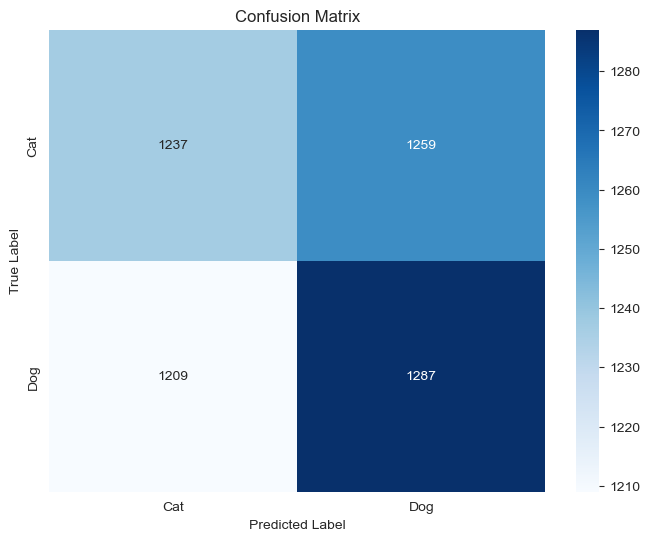

In [49]:
test_steps = test_generator.samples // test_generator.batch_size
test_generator.reset()
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes[:len(predicted_labels)]

print('Classification Report:')
labels = ['Cat', 'Dog']
report = classification_report(true_labels, predicted_labels, target_names=labels)
print(report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Evaluate the Model on the Test Set:

In [51]:
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


2024-11-04 17:53:20.926878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


157/157 [==============================] - 64s 409ms/step - loss: 0.0666 - accuracy: 0.9778
Test Loss: 0.0666
Test Accuracy: 97.78%


# Model 3:  VGG16 

In [56]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

### Load Pre-trained VGG16 Model:

In [57]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False


### Add Custom Layers for Binary Classification:

In [58]:
x = base_model.output
x = Flatten()(x)  
x = Dense(256, activation='relu')(x)  
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

### Compile the Model:

In [59]:
model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a small learning rate for transfer learning
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Fit the Model & Fine-Tuning:

In [60]:
history = model.fit(
    train_generator,
    epochs=10, 
    validation_data=test_generator
)

Epoch 1/10


2024-11-04 18:51:27.995240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8002

2024-11-04 19:05:29.782237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 1047s 2s/step - loss: 0.4206 - accuracy: 0.8002 - val_loss: 0.2583 - val_accuracy: 0.8932
Epoch 2/10
625/625 [==============================] - 1025s 2s/step - loss: 0.3531 - accuracy: 0.8424 - val_loss: 0.2835 - val_accuracy: 0.8800
Epoch 3/10
625/625 [==============================] - 1033s 2s/step - loss: 0.3325 - accuracy: 0.8510 - val_loss: 0.2348 - val_accuracy: 0.9040
Epoch 4/10
625/625 [==============================] - 1033s 2s/step - loss: 0.3308 - accuracy: 0.8507 - val_loss: 0.2365 - val_accuracy: 0.8990
Epoch 5/10
625/625 [==============================] - 1041s 2s/step - loss: 0.3139 - accuracy: 0.8598 - val_loss: 0.2289 - val_accuracy: 0.9058
Epoch 6/10
625/625 [==============================] - 1043s 2s/step - loss: 0.3106 - accuracy: 0.8606 - val_loss: 0.2341 - val_accuracy: 0.9044
Epoch 7/10
625/625 [==============================] - 1518s 2s/step - loss: 0.3091 - accuracy: 0.8614 - val_loss: 0.2233 - val_accuracy: 0.9102
Epo

In [61]:
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs=5, 
    validation_data=test_generator
)


2024-11-04 22:02:16.986437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9294 

2024-11-05 00:36:23.254281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 9479s 15s/step - loss: 0.1723 - accuracy: 0.9294 - val_loss: 0.1400 - val_accuracy: 0.9466
Epoch 2/5
625/625 [==============================] - 33116s 53s/step - loss: 0.1154 - accuracy: 0.9522 - val_loss: 0.0745 - val_accuracy: 0.9666
Epoch 3/5
625/625 [==============================] - 3501s 6s/step - loss: 0.0927 - accuracy: 0.9633 - val_loss: 0.0607 - val_accuracy: 0.9756
Epoch 4/5
625/625 [==============================] - 2965s 5s/step - loss: 0.0814 - accuracy: 0.9690 - val_loss: 0.0676 - val_accuracy: 0.9722
Epoch 5/5
625/625 [==============================] - 2968s 5s/step - loss: 0.0683 - accuracy: 0.9728 - val_loss: 0.0635 - val_accuracy: 0.9752


### Evaluate the Model on the Test Set:

In [62]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

2024-11-05 12:43:51.731031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


157/157 [==============================] - 199s 1s/step - loss: 0.0635 - accuracy: 0.9752
Test Loss: 0.0635
Test Accuracy: 97.52%


### Plot Training and Validation Curves:

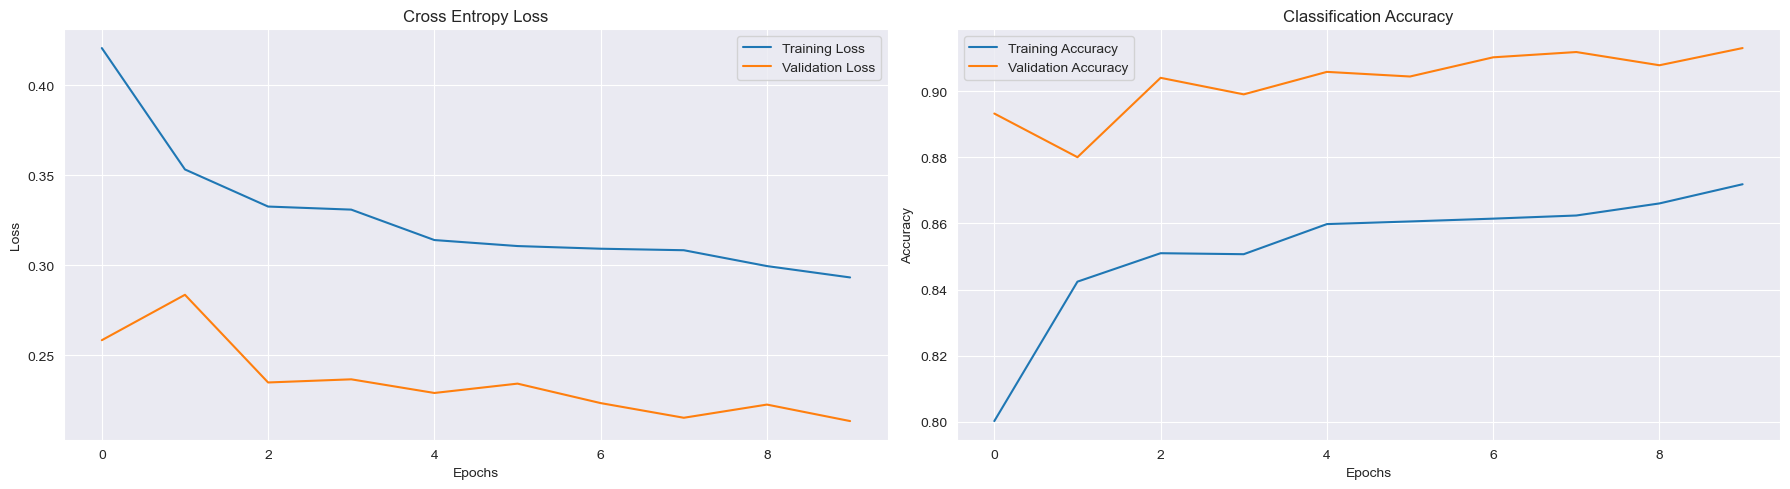

In [63]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Plot Classification Report and Confusion Matrix:

2024-11-05 12:48:31.340179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


156/156 [==============================] - 212s 1s/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.48      0.49      2496
         Dog       0.50      0.51      0.50      2496

    accuracy                           0.50      4992
   macro avg       0.50      0.50      0.50      4992
weighted avg       0.50      0.50      0.50      4992



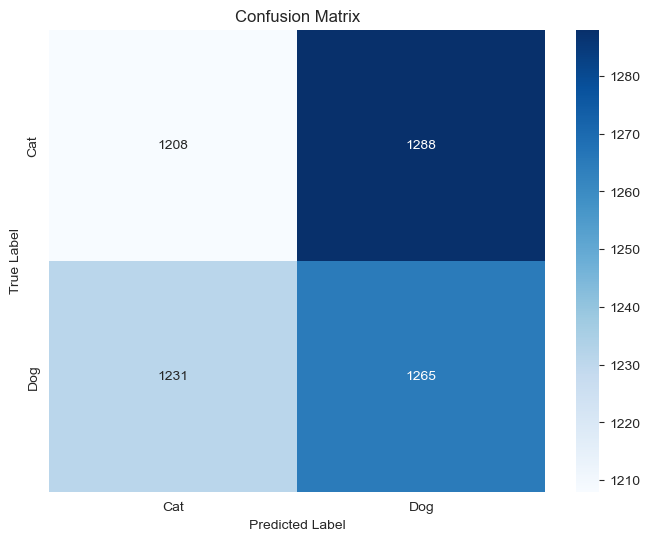

In [64]:
test_steps = test_generator.samples // test_generator.batch_size
test_generator.reset()
predictions = model.predict(test_generator, steps=test_steps, verbose=1)

predicted_labels = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes[:len(predicted_labels)]

print('Classification Report:')
labels = ['Cat', 'Dog']
report = classification_report(true_labels, predicted_labels, target_names=labels)
print(report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()